# Cleaning Dataset 
_____

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import missingno as msno

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

import plotly.figure_factory as ft 

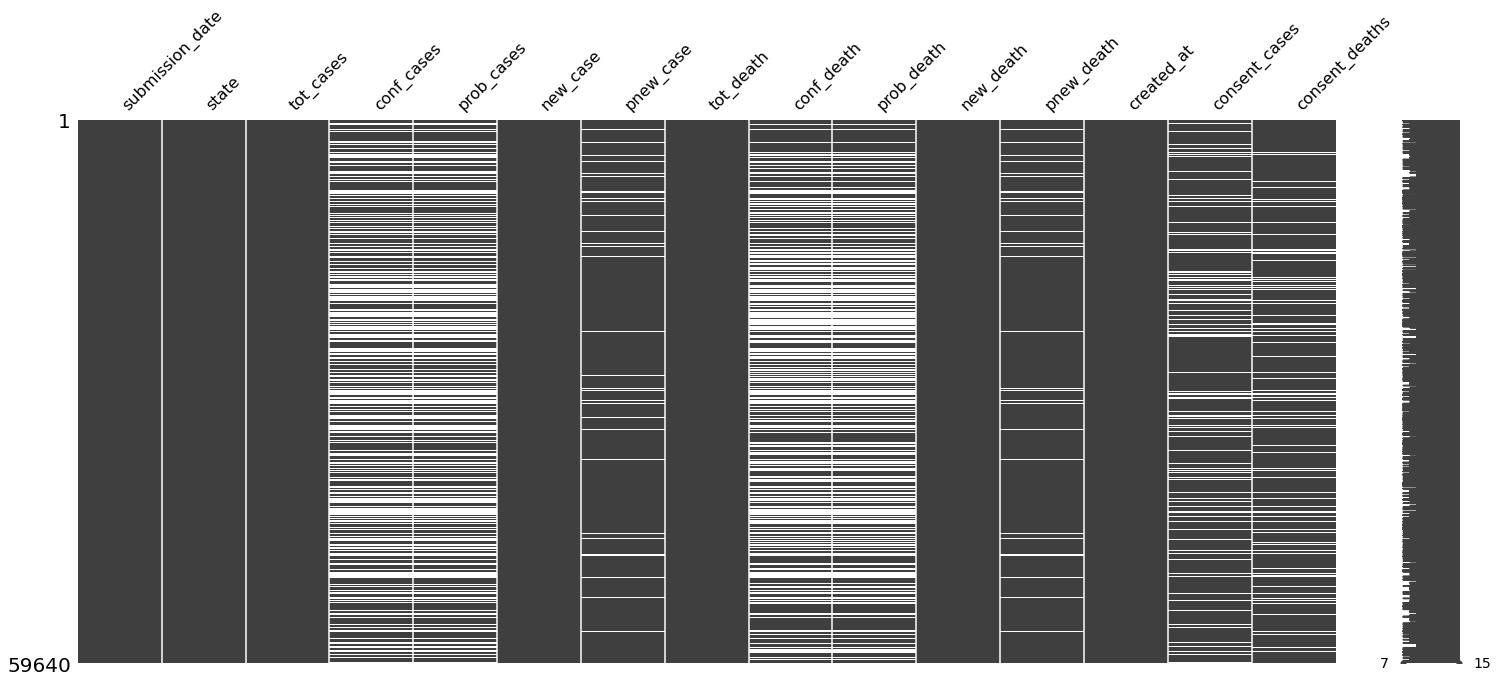

In [122]:
covid = pd.read_csv('../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
covid['submission_date'] = pd.to_datetime(covid['submission_date'])
msno.matrix(covid);

In [123]:
covid = covid[['submission_date','state','tot_cases','new_case','tot_death','new_death']]
covid.set_index('submission_date', inplace=True)
covid.sort_index(inplace=True)
covid

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,"348,570",0,"1,682",0
2022-10-11,MP,"13,171",0,40,0
2022-10-11,UT,"1,040,147",0,"5,028",0


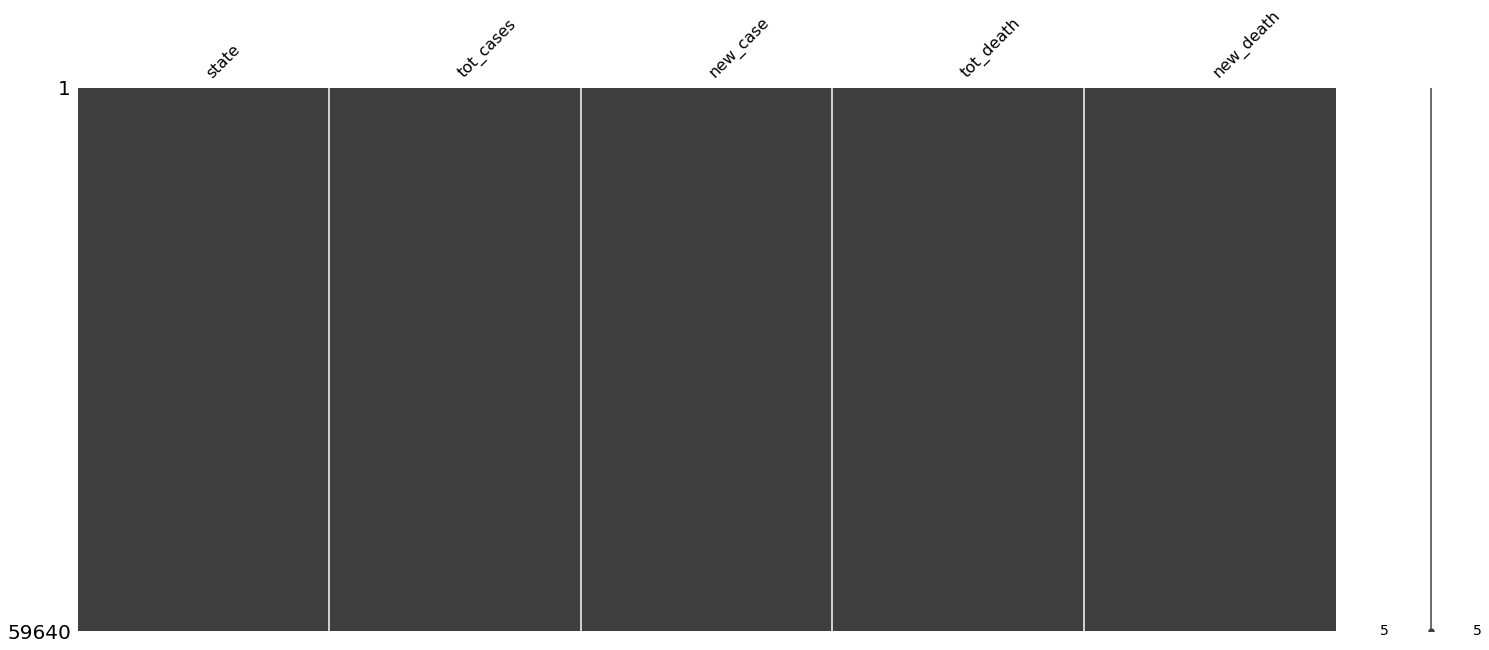

In [124]:
msno.matrix(covid);

In [125]:
col =['tot_cases', 'new_case', 'tot_death', 'new_death']
for c in col:
    covid[c] = covid[c].map( lambda x: x.replace(',','')).astype(int)
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [126]:
covid.shape

(59640, 5)

In [127]:
df_cases = covid.copy()

#  EDA - Covid Cases Overall  US 
_____

I will perform EDA in US cases so I need to sum cases from all states. \
To do this I will sum the cases for the same dates using group by dates. \
I can't use tot_cases because this column is acumulative so I will sum the new cases.

In [128]:
# Creating a copy of dataset to perform EDA
df = covid.copy()
df

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,348570,0,1682,0
2022-10-11,MP,13171,0,40,0
2022-10-11,UT,1040147,0,5028,0


In [129]:
df = df.groupby(by=df.index).sum()
df.head()

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0


We trying to build a Time Series on covid cases since the begining of the pandemic so first we need to check for some assumptions like stationarity, trends and seasonalities on the dataset.

In [130]:
# dropping columns
df.drop(columns=['tot_cases','tot_death','new_death'], inplace=True)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2020-01-22 to 2022-10-11
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   new_case  994 non-null    int64
dtypes: int64(1)
memory usage: 15.5 KB


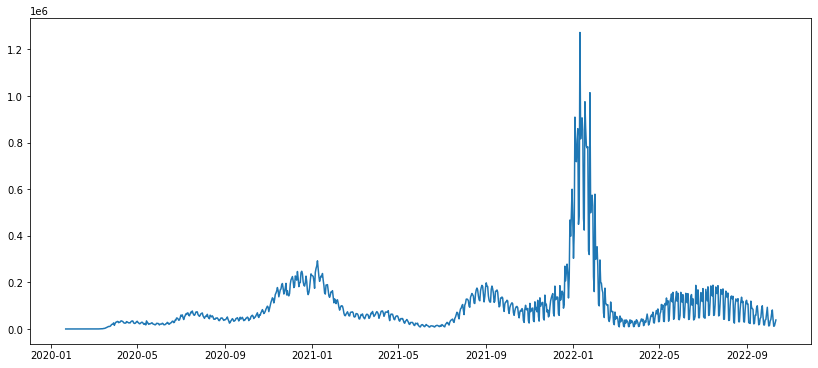

In [132]:
plt.figure(figsize=(14,6))
plt.plot(df['new_case']);

In [133]:
# Resample data to smothing out
df = df.resample('W').mean()
df_cases_diff = df.copy()
df.head()

,new_case
submission_date,
2020-01-26,1.600000
2020-02-02,0.714286
2020-02-09,1.000000
2020-02-16,0.571429
2020-02-23,3.428571


In [134]:
df['moving_average_1'] = df['new_case'].rolling(window=1).mean()
df['moving_average_4'] = df['new_case'].rolling(window=4).mean()
df['moving_average_13'] = df['new_case'].rolling(window=13).mean()
df.dropna(inplace=True)
df.head()

,new_case,moving_average_1,moving_average_4,moving_average_13
submission_date,,,,
2020-04-19,27436.857143,27436.857143,25772.964286,8494.298901
2020-04-26,30087.571429,30087.571429,28939.857143,10808.604396
2020-05-03,27584.571429,27584.571429,29096.714286,12930.439560
2020-05-10,24957.142857,24957.142857,27516.535714,14850.142857
2020-05-17,24088.142857,24088.142857,26679.357143,16703.032967


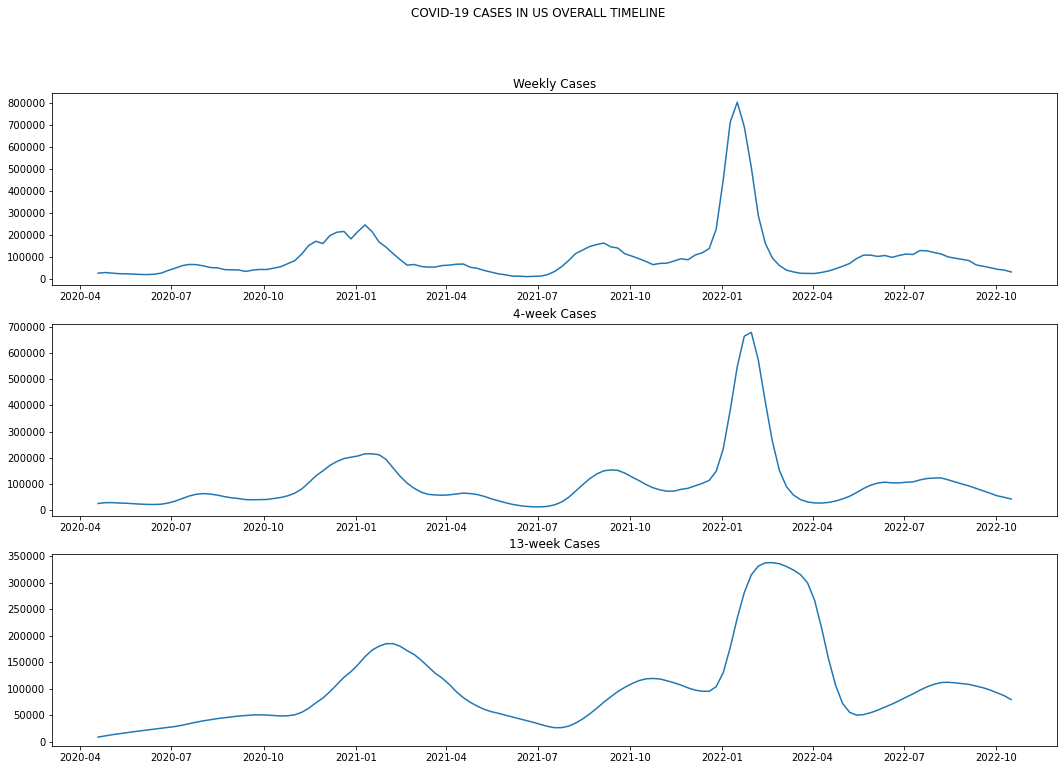

In [135]:
fig, axes = plt.subplots(nrows=3, figsize=(18,12))

axes[0].plot(df['moving_average_1'])
axes[1].plot(df['moving_average_4'])
axes[2].plot(df['moving_average_13'])

fig.suptitle('COVID-19 CASES IN US OVERALL TIMELINE');
axes[0].title.set_text('Weekly Cases')
axes[1].title.set_text('4-week Cases')
axes[2].title.set_text('13-week Cases')


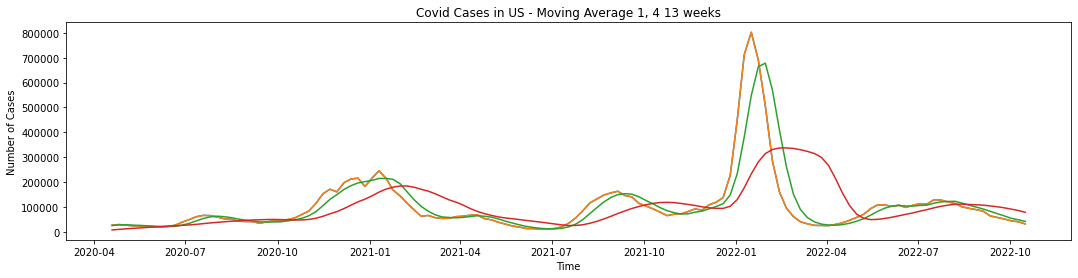

In [136]:
plt.figure(figsize=(18,4))
plt.plot(df)
plt.title('Covid Cases in US - Moving Average 1, 4 13 weeks')
plt.xlabel('Time')
plt.ylabel('Number of Cases');

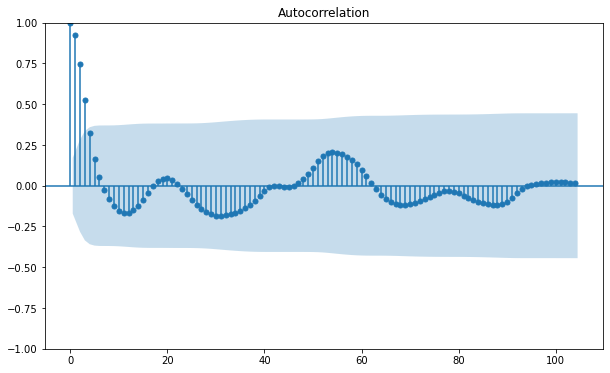

In [137]:
# Generate the ACF plot on Weekly Sales data up to 52 time periods.
plt.rc("figure", figsize=(10,6))
plot_acf(df['new_case'], lags = 104);

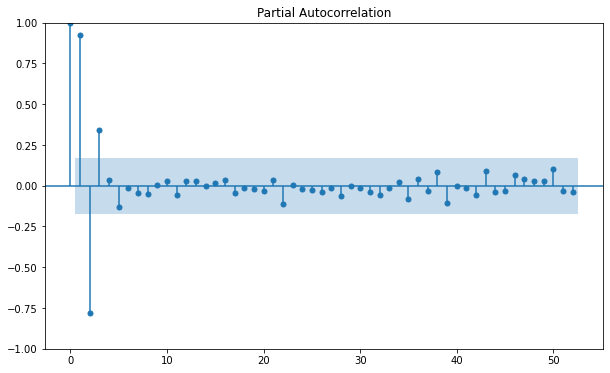

In [138]:
plt.rc("figure", figsize=(10,6))
plot_pacf(df['new_case'], lags = 52, method='ywm' );

### Evaluating Stationary
---

Applying Dickey-Test to check our hypotesis:

In [139]:
# Run ADF test on original (non-differenced!) data.
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['new_case']))

Test Statistic   -3.264758
p-value           0.016529
dtype: float64

Because our p (0.016529) is bigger than alpha (0.01) we can not  accept that our series "new_cases" is stationary. Let's apply diff() on data. 

In [140]:
# Run ADF test on differenced once data.
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on differenced once data.
interpret_dftest(adfuller(df['new_case'].diff().dropna()))

Test Statistic   -8.312911e+00
p-value           3.746933e-13
dtype: float64

After apply diff() our p (3.746933e-13) is smaller than alpha (0.01) and now we can accept that our series "new_cases" is stationary. The value of d will be '1' and we going to gridsearch p and q values.

In [141]:
# Create train-test split.
y_train, y_test = train_test_split(df['new_case'], test_size = 0.1,shuffle = False)

In [142]:
# Checking train tail
y_train.tail()

submission_date
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
2022-07-10    111881.000000
Freq: W-SUN, Name: new_case, dtype: float64

In [143]:
# Checking the test head
y_test.head()

submission_date
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
2022-08-14    101213.571429
Freq: W-SUN, Name: new_case, dtype: float64

#### Building a ARIMA(0,1,0)

In [144]:
# Instantiate best model.
arima_010 = ARIMA(endog = y_train, order = (0, 1, 0))

# Fit ARIMA model.
model_010 = arima_010.fit()

# Generate predictions based on test set.
preds_010 = model_010.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_010 = model_010.predict(start = y_train.index[0], end = y_train.index[-1])

from sklearn import metrics
metrics.mean_squared_error(y_test, preds_010)

1904625386.0087464

Text(0.5, 1.0, ' ARIMA(0, 1, 0) Predictions')

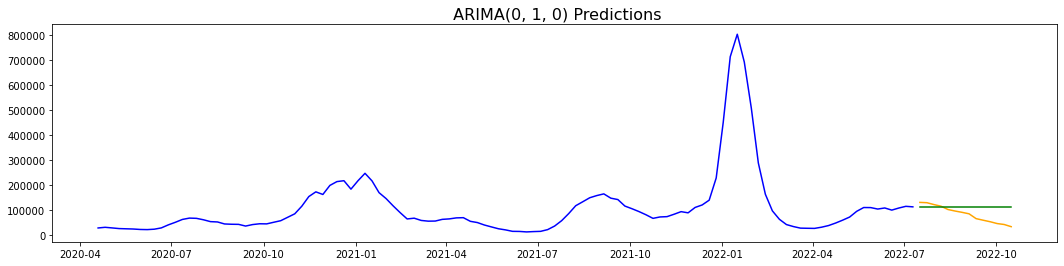

In [145]:
# Plotting the model ARIMA(0,1,0)
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_010, color = 'green')

plt.title(label = ' ARIMA(0, 1, 0) Predictions', fontsize=16)

#### Building a ARIMA(3,0,1)

In [146]:
# Instantiate best model.
arima_301 = ARIMA(endog = y_train, order = (3, 0, 1))

# Fit ARIMA model.
model_301 = arima_301.fit()

# Generate predictions based on test set.
preds_301 = model_301.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_301 = model_301.predict(start = y_train.index[0], end = y_train.index[-1])

from sklearn import metrics
metrics.mean_squared_error(y_test, preds_301)

1670139099.9838376

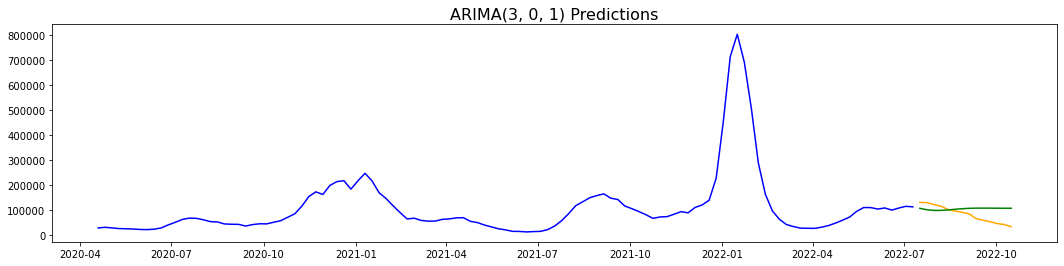

In [147]:
# Plotting  the model ARIMA(3,0,1).
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_301, color = 'green')

plt.title(label = 'ARIMA(3, 0, 1) Predictions', fontsize=16);

#### Building a ARIMA(52, 0, 1)

In [148]:
# Instantiate best model.
arima_5201 = ARIMA(endog = y_train, order = (52, 0, 1))

# Fit ARIMA model.
model_5201 = arima_5201.fit()

# Generate predictions based on test set.
preds_5201 = model_5201.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_5201 = model_5201.predict(start = y_train.index[0], end = y_train.index[-1])

from sklearn import metrics
metrics.mean_squared_error(y_test, preds_5201)

8743233752.031364

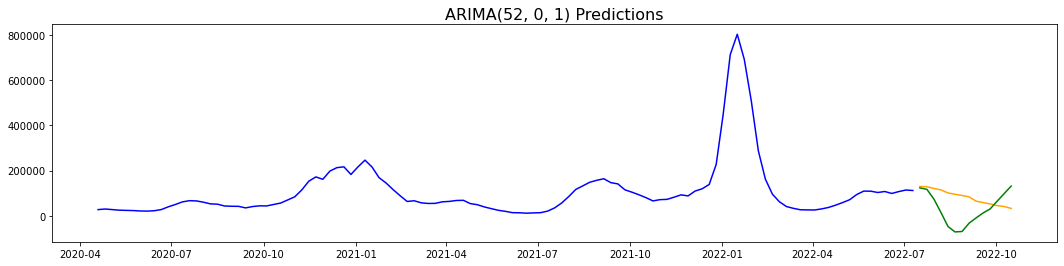

In [149]:
# Plotting  the model ARIMA(52,0,1).
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_5201, color = 'green')

plt.title(label = 'ARIMA(52, 0, 1) Predictions', fontsize=16);

#### Building a ARIMA(22, 0, 1)

In [150]:
# Instantiate best model.
arima_2201 = ARIMA(endog = y_train, order = (22, 0, 1))

# Fit ARIMA model.
model_2201 = arima_2201.fit()

# Generate predictions based on test set.
preds_2201 = model_2201.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_2201 = model_2201.predict(start = y_train.index[0], end = y_train.index[-1])

from sklearn import metrics
metrics.mean_squared_error(y_test, preds_2201)

2800304132.0058336

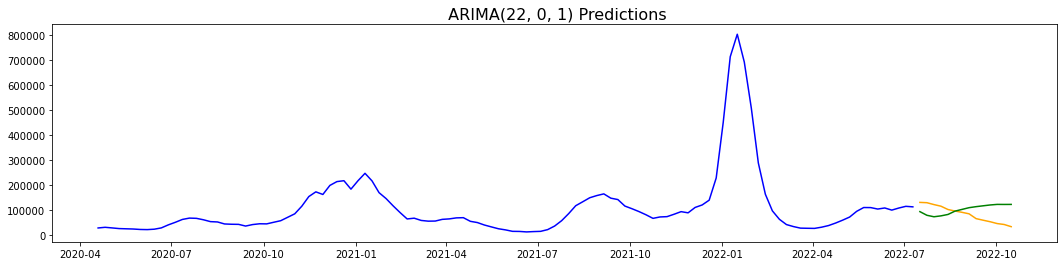

In [151]:
# Plotting  the model ARIMA(22,0,1).
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_2201, color = 'green')

plt.title(label = ' ARIMA(22, 0, 1) Predictions', fontsize=16);

### Building model SARIMA(3, 0, 1) x (1, 1, 1, 22) model.
----

In [152]:
# Fit a SARIMA(3, 0, 1) x (1, 1, 1, 22) model.
sarima = SARIMAX(endog = y_train,
                  order = (3, 0, 1),                # (p, d, q)
                  seasonal_order=(1, 1, 1, 22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

# Generate predictions based on test set.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])

# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01876D+01    |proj g|=  1.53410D+00

At iterate    5    f=  9.61380D+00    |proj g|=  4.07625D-02

At iterate   10    f=  9.60119D+00    |proj g|=  5.82532D-03

At iterate   15    f=  9.59915D+00    |proj g|=  1.00264D-03

At iterate   20    f=  9.59915D+00    |proj g|=  1.96093D-04

At iterate   25    f=  9.59912D+00    |proj g|=  1.21219D-03

At iterate   30    f=  9.59910D+00    |proj g|=  3.42874D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

436284355.8369504

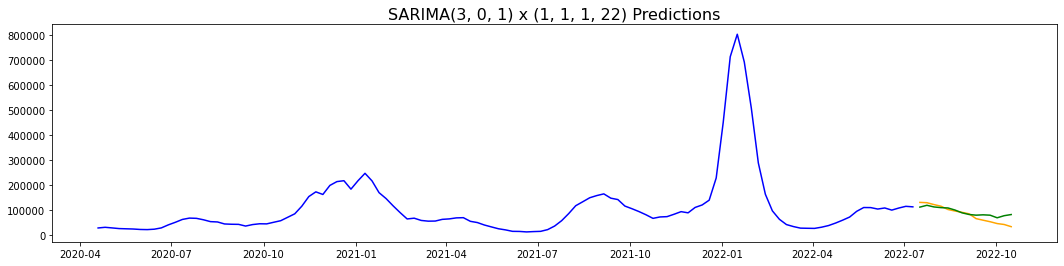

In [153]:
# Plotting SARIMA
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

    #order = (3, 0, 1),                # (p, d, q)
     # seasonal_order=(1,1,1,22))     

plt.title(label = 'SARIMA(3, 0, 1) x (1, 1, 1, 22) Predictions', fontsize=16)
plt.show();

In [154]:
df_cases.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0


In [155]:
df_cases_diff.head()

,new_case
submission_date,
2020-01-26,1.600000
2020-02-02,0.714286
2020-02-09,1.000000
2020-02-16,0.571429
2020-02-23,3.428571


In [156]:
df_cases_diff['diff_1'] = df_cases_diff['new_case'].diff()
df_cases_diff['diff_2'] = df_cases_diff['new_case'].diff().diff()
df_cases_diff.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-01-26,1.600000,NaN,NaN
2020-02-02,0.714286,-0.885714,NaN
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714


In [157]:
df_cases_diff.dropna(inplace=True)
df_cases_diff.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714
2020-03-01,7.428571,4.000000,1.142857
2020-03-08,103.142857,95.714286,91.714286


In [158]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df_cases_diff['new_case']))

Test Statistic   -3.320787
p-value           0.013974
dtype: float64

In [159]:
# Create train-test split.
y_train, y_test = train_test_split(df_cases_diff['new_case'], test_size = 0.1,shuffle = False)

In [160]:
y_train.tail()

submission_date
2022-06-05    103067.428571
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
Freq: W-SUN, Name: new_case, dtype: float64

In [161]:
y_test.head()

submission_date
2022-07-10    111881.000000
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
Freq: W-SUN, Name: new_case, dtype: float64

In [162]:
# Fit a SARIMA(2, 0, 2) x (1, 1, 1, 52) model.
#CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
#Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,16).
#This model has an MSE of 990000000000000000.
#(1,0,0): 328044210.2485147
#(3,1,1):1835103241.9625137
sarima = SARIMAX(endog = y_train,
                  order = (1, 0, 0),                # (p, d, q)
                  seasonal_order=(0,0,0,22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21685D+01    |proj g|=  2.14268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.274D-06   1.217D+01
  F =   12.168175861504078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [163]:
# Generate predictions based on test set. # Evaluate predictions MSE.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])
# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

328044210.2485147

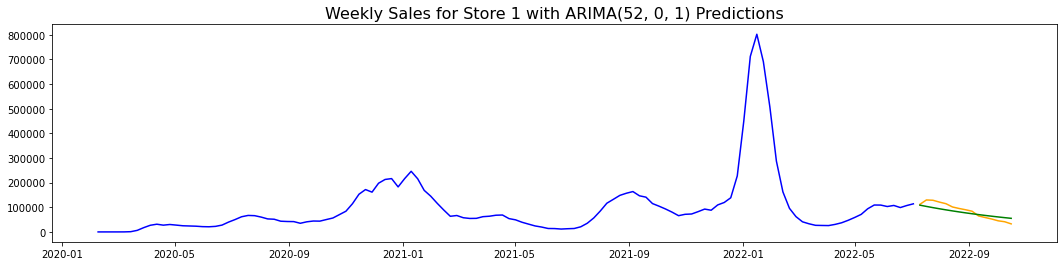

In [164]:
# Plot data.
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

plt.title(label = 'Weekly Sales for Store 1 with ARIMA(52, 0, 1) Predictions', fontsize=16)
plt.show();

In [165]:
y_train.shape

(126,)

In [166]:
y_test.shape

(15,)

In [167]:
# Create train-test split.
y_train, y_test = train_test_split(df_cases_diff['new_case'], test_size = 0.1,shuffle = False)

In [168]:
metrics.mean_squared_error(y_test, preds_sarima)

328044210.2485147

In [169]:
# Starting MSE and (P, D, Q).
def my_gridsearch():
    mse = 99 * (10 ** 16)
    final_p = 0
    final_d = 0
    final_q = 0
    final_P = 0
    final_D = 0
    final_Q = 0

    for p in range(2):
        for q in range(2):
            for d in range(2):
                for P in range(3):
                    for Q in range(3):
                        for D in range(3):
                            try:
                                sarima = SARIMAX(endog = y_train,
                                                order = (p, d, q),              # (p, d, q)
                                                seasonal_order = (P, D, Q, 22))  # (P, D, Q, S)
                                
                                print(P, D, Q)
                                # Fit SARIMA model.
                                model = sarima.fit()
                                preds_sarima = model.predict(start = y_test.index[0], end = y_test.index[-1])
                                print(f'The MSE for ({p}, {d}, {q})x({P},{D},{Q},22) is: {metrics.mean_squared_error(y_test, preds_sarima)}')#

                                                # Save for final report.
                                if mse > metrics.mean_squared_error(y_test, preds_sarima):
                                    mse = metrics.mean_squared_error(y_test, preds_sarima)
                                    
                                    final_p = p
                                    final_d = d
                                    final_q = q
                                    final_P = P
                                    final_D = D
                                    final_Q = Q
                            except:

                                    pass
        print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},22).')
        print(f'This model has an MSE of {mse}.')
    return print('here!')

In [170]:
# 27690096390.04778
# 31324938754.810467
# 328044210.2485147
# CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
# The MSE for (1, 1, 1)x(2,2,2,22) is: 31324938754.810467

# Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,22).
# This model has an MSE of 328044210.2485147.

### Cases by State
____

In [171]:
df_cases.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0


In [172]:
df_cases.groupby(by='state').sum()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AS,1382283,8250,5776,34
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383


In [173]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [217]:
df_ = df_cases.loc['2022-06':'2022-10'].groupby(by='state').sum()
df5_state_cases = df_.sort_values(by='tot_cases', ascending=False).head(5)
states5_list = df5_state_cases.index
states5_list

In [177]:
df_cases.groupby(by='state').sum().sort_values(by='new_case', ascending=False)

,tot_cases,new_case,tot_death,new_death
state,,,,
CA,4364733842,11107087,50457009,95414
TX,3307212352,7691340,47538683,89344
FL,2877176184,7135916,40188788,81807
IL,1535904620,3778171,22194980,39791
NY,1301856010,3259603,17308667,29549
PA,1328107988,3249979,24628308,47169
NC,1233122110,3221966,13187799,26889
OH,1276191903,3149589,19056947,36187
GA,1256065315,2898910,20057017,39908


In [178]:
df_cases.groupby(by='state').sum().shape

(60, 4)

In [179]:
df_fips = pd.read_csv('../data/states_fips.csv')
df_fips.head(50)

,name,postal_code,fips
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6
5,Colorado,CO,8
6,Connecticut,CT,9
7,Delaware,DE,10
8,District of Columbia,DC,11
9,Florida,FL,12


In [180]:
list_state = list(df_cases.groupby(by='state').sum().index)
list_fips = list(df_fips['postal_code'])

In [181]:
set(list_state) - set(list_fips)

{'FSM', 'NYC', 'PW', 'RMI'}

In [182]:
# These are not US state
# FSM: Federated States of Micronesia
# PW: Palau
# RMI: Republic of Marshall Islands
not_state_list = ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']

In [252]:
df_ = df_cases.loc['2022-06':'2022-10'].groupby(by='state').sum()
df5_state_cases = df_.sort_values(by='new_case', ascending=False).head(5)
states5_list = df5_state_cases.index
states5_list

Index(['CA', 'TX', 'FL', 'IL', 'NC'], dtype='object', name='state')

In [258]:
#df_jul_set = df_cases.loc['2022-07':'2022-09']
df_jul_set = df_cases.loc['2022-07':'2022-09']
df_jul_set[df_jul_set['state']==('CA'or'TX'or 'FL')]

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2022-07-01,CA,10143414,67396,91701,185
2022-07-02,CA,10143414,0,91701,0
2022-07-03,CA,10143414,0,91701,0
2022-07-04,CA,10143414,0,91701,0
2022-07-05,CA,10212491,69077,91795,94
...,...,...,...,...,...
2022-09-26,CA,11220161,0,95009,0
2022-09-27,CA,11220161,0,95009,0
2022-09-28,CA,11220161,0,95009,0


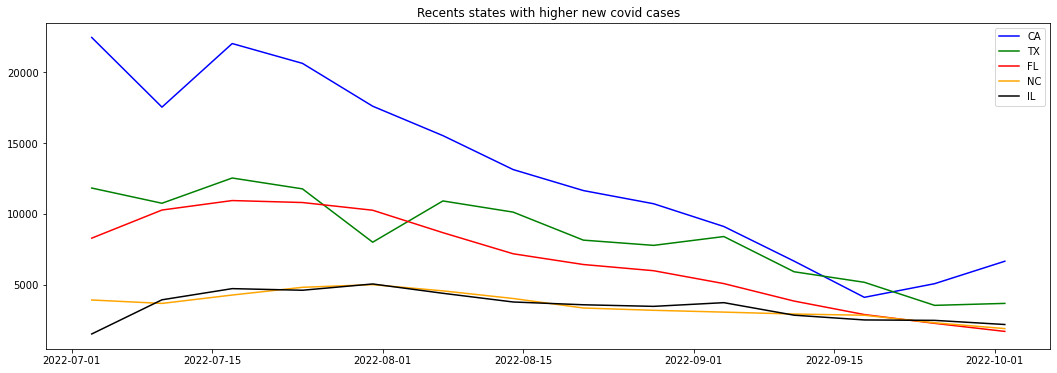

In [271]:
#['CA', 'TX', 'FL', 'IL', 'NC']
plt.figure(figsize=(18,6))
plt.plot(df_jul_set[df_jul_set['state']=='CA']['new_case'].resample('W').mean(), color='blue', label='CA')
plt.plot(df_jul_set[df_jul_set['state']=='TX']['new_case'].resample('W').mean(), color='green', label='TX')
plt.plot(df_jul_set[df_jul_set['state']=='FL']['new_case'].resample('W').mean(), color='red', label='FL')
plt.plot(df_jul_set[df_jul_set['state']=='NC']['new_case'].resample('W').mean(), color='orange', label='NC')
plt.plot(df_jul_set[df_jul_set['state']=='IL']['new_case'].resample('W').mean(), color='black', label='IL')

plt.title('Five States with Recent Higher New Covid Cases Average')
plt.xlabel('')
plt.ylabel('')
plt.legend();


In [256]:
df_us = df_cases.groupby(by='state').sum()
df_us.shape

(60, 4)

In [185]:
df_us.loc['FSM']

tot_cases    753724
new_case      22005
tot_death      1997
new_death        51
Name: FSM, dtype: int64

In [186]:
# Deleting theses 'states' ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']
# Keeping DC and NYC. Total of 52 'US states'
df_us.drop(index=not_state_list,inplace=True)
df_us.shape

(52, 4)

In [187]:
df_us.sort_index()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383
DE,123511033,310527,1674285,3094


In [188]:
##!pip install plotly-geo==1.0.0
##!pip install geopandas==0.3.0
##!pip install pyshp==1.2.10
##!pip install shapely==1.6.3

In [189]:
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd

In [190]:
df_us.head()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414


In [191]:
total_covid_cases = df_us['new_case'].sum()
total_covid_cases

94811167

In [192]:
df_us['pct_cases'] = df_us['new_case']/total_covid_cases*100
df_us.head().sort_values(by='pct_cases', ascending=False)

,tot_cases,new_case,tot_death,new_death,pct_cases
state,,,,,
CA,4364733842,11107087,50457009,95414,11.714957
AZ,978893192,2275235,15992140,31644,2.399754
AL,638327202,1528319,10915844,20498,1.611961
AR,403775153,954552,5830937,12041,1.006793
AK,103800015,282632,533125,1186,0.298100


In [193]:
import plotly.graph_objects as go

import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(
    data = go.Choropleth(
    locations = df_jul_set.index, # Spatial coordinates
    z = df_jul_set['new_death'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = ' US Covid Deaths by State Overall',
    geo_scope='usa', # limite map scope to USA
)

fig.show()


In [194]:
import plotly.graph_objects as go

import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(
    data = go.Choropleth(
    locations = df_us.index, # Spatial coordinates
    z = df_us['pct_cases'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = ' US Covid Cases by State Overall',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

## EDA - COVID Deaths in US
____

In [195]:
df_deaths = df_cases.copy()
df_deaths.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.7+ MB


In [196]:
df_deaths = df_deaths.groupby(by=df_deaths.index).sum()
df_deaths.head()

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0


In [197]:
df_deaths.drop(columns=['tot_cases','tot_death','new_case'], inplace=True)


In [198]:
df_deaths.sort_values(by='new_death', ascending=True)

,new_death
submission_date,
2020-01-22,0
2020-02-12,0
2020-02-13,0
2020-02-14,0
2020-02-15,0
...,...
2021-01-28,3880
2021-01-27,3955
2021-01-07,4000


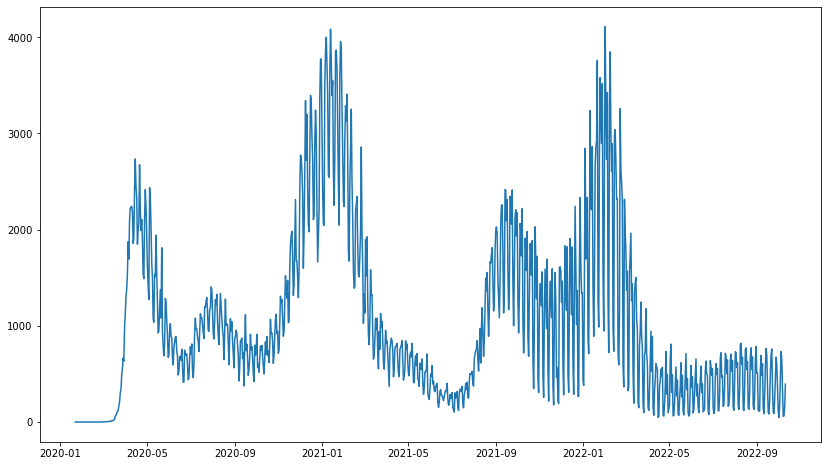

In [199]:
plt.figure(figsize=(14,8))
plt.plot(df_deaths['new_death']);

# Vacination data
____


In [200]:
df_vacc=pd.read_csv('../data/clean_data/covid_vaccination_trends_clean.csv', low_memory=False)

In [201]:
df_vacc['Date'] = pd.to_datetime(df_vacc['Date'])
df_vacc.set_index('Date', inplace=True)
df_vacc.sort_index(inplace=True)
df_vacc.head(20)

,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,Administered_Dose1_Pop_Pct,Administered_daily_change_report,Administered_daily_change_report_7dayroll,...,Series_Complete_Day_Rolling_Average,Series_Complete_Pop_Pct,Booster_Daily,Booster_Cumulative,Booster_7_Day_Rolling_Average,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Daily,Second_Booster_50Plus_Cumulative,Second_Booster_50Plus_7_Day_Rolling_Average,Second_Booster_50Plus_Vax_Pct
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-13,GU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,FM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,MA,2.0,2.0,2.0,22.0,22.0,22.0,0.0,2.0,2.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,NY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,AZ,4423.0,4423.0,4423.0,3116.0,3116.0,3116.0,0.0,4423.0,4423.0,...,1097.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,NJ,1342.0,1342.0,1342.0,1083.0,1083.0,1083.0,0.0,1342.0,1342.0,...,515.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,IA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,MA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,OH,4.0,4.0,4.0,48.0,48.0,48.0,0.0,4.0,4.0,...,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
df_ca_vcc= df_vacc[df_vacc["Location"]=='CA']
df_ca_vcc.head(10)

,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,Administered_Dose1_Pop_Pct,Administered_daily_change_report,Administered_daily_change_report_7dayroll,...,Series_Complete_Day_Rolling_Average,Series_Complete_Pop_Pct,Booster_Daily,Booster_Cumulative,Booster_7_Day_Rolling_Average,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Daily,Second_Booster_50Plus_Cumulative,Second_Booster_50Plus_7_Day_Rolling_Average,Second_Booster_50Plus_Vax_Pct
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-13,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,CA,2660.0,2660.0,2660.0,2000.0,2000.0,2000.0,0.0,2660.0,2660.0,...,1028.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-14,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-14,CA,65.0,2725.0,1363.0,57.0,2057.0,1029.0,0.0,65.0,1363.0,...,525.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-15,CA,1317.0,4042.0,1347.0,1492.0,3549.0,1183.0,0.0,1317.0,1347.0,...,362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-15,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-16,CA,9794.0,13836.0,3459.0,10261.0,13810.0,3453.0,0.0,9794.0,3459.0,...,277.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-16,CA,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-17,CA,29691.0,43527.0,8705.0,30074.0,43884.0,8777.0,0.1,29691.0,8705.0,...,235.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [203]:
df_ca_cases = df_cases[df_cases['state']=='CA']


In [204]:
df_ca_cases.shape

(994, 5)

In [205]:
df_var = pd.merge(df_ca_vcc, df_ca_cases, left_index=True, right_index=True)
df_var.head(10)

,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,Administered_Dose1_Pop_Pct,Administered_daily_change_report,Administered_daily_change_report_7dayroll,...,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Daily,Second_Booster_50Plus_Cumulative,Second_Booster_50Plus_7_Day_Rolling_Average,Second_Booster_50Plus_Vax_Pct,state,tot_cases,new_case,tot_death,new_death
2020-12-13,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,CA,1551766,30334,20995,183
2020-12-13,CA,2660.0,2660.0,2660.0,2000.0,2000.0,2000.0,0.0,2660.0,2660.0,...,0.0,0.0,0.0,0.0,0.0,CA,1551766,30334,20995,183
2020-12-14,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,CA,1585044,33278,21088,93
2020-12-14,CA,65.0,2725.0,1363.0,57.0,2057.0,1029.0,0.0,65.0,1363.0,...,0.0,0.0,0.0,0.0,0.0,CA,1585044,33278,21088,93
2020-12-15,CA,1317.0,4042.0,1347.0,1492.0,3549.0,1183.0,0.0,1317.0,1347.0,...,0.0,0.0,0.0,0.0,0.0,CA,1617370,32326,21178,90
2020-12-15,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,CA,1617370,32326,21178,90
2020-12-16,CA,9794.0,13836.0,3459.0,10261.0,13810.0,3453.0,0.0,9794.0,3459.0,...,0.0,0.0,0.0,0.0,0.0,CA,1671081,53711,21410,232
2020-12-16,CA,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,CA,1671081,53711,21410,232
2020-12-17,CA,29691.0,43527.0,8705.0,30074.0,43884.0,8777.0,0.1,29691.0,8705.0,...,0.0,0.0,0.0,0.0,0.0,CA,1723362,52281,21817,407
2020-12-17,CA,269.0,273.0,55.0,0.0,0.0,0.0,0.0,0.0,55.0,...,0.0,0.0,0.0,0.0,0.0,CA,1723362,52281,21817,407


In [206]:
df_var.drop(columns=['Location', 'Administered_Daily', 'Administered_Cumulative',
       'Administered_7_Day_Rolling_Average',
       'Admin_Dose_1_Cumulative', 'Admin_Dose_1_Day_Rolling_Average',
       'Administered_Dose1_Pop_Pct', 'Administered_daily_change_report',
       'Administered_daily_change_report_7dayroll', 'Series_Complete_Daily',
       'Series_Complete_Cumulative', 'Series_Complete_Day_Rolling_Average',
       'Series_Complete_Pop_Pct', 'Booster_Cumulative',
       'Booster_7_Day_Rolling_Average', 'Additional_Doses_Vax_Pct',
       'Second_Booster_50Plus_Cumulative',
       'Second_Booster_50Plus_7_Day_Rolling_Average',
       'Second_Booster_50Plus_Vax_Pct', 'tot_cases',
       'tot_death'], inplace=True)

In [207]:
df_var.columns

Index(['Admin_Dose_1_Daily', 'Booster_Daily', 'Second_Booster_50Plus_Daily',
       'state', 'new_case', 'new_death'],
      dtype='object')

In [208]:
df_var

,Admin_Dose_1_Daily,Booster_Daily,Second_Booster_50Plus_Daily,state,new_case,new_death
2020-12-13,0.0,0.0,0.0,CA,30334,183
2020-12-13,2000.0,0.0,0.0,CA,30334,183
2020-12-14,0.0,0.0,0.0,CA,33278,93
2020-12-14,57.0,0.0,0.0,CA,33278,93
2020-12-15,1492.0,0.0,0.0,CA,32326,90
...,...,...,...,...,...,...
2022-06-17,5780.0,16230.0,20975.0,CA,42000,133
2022-06-18,2980.0,7304.0,7929.0,CA,0,0
2022-06-19,1450.0,3244.0,3176.0,CA,0,0
2022-06-20,4671.0,11947.0,15548.0,CA,0,0


In [209]:
df_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1107 entries, 2020-12-13 to 2022-06-21
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Admin_Dose_1_Daily           1107 non-null   float64
 1   Booster_Daily                1107 non-null   float64
 2   Second_Booster_50Plus_Daily  1107 non-null   float64
 3   state                        1107 non-null   object 
 4   new_case                     1107 non-null   int64  
 5   new_death                    1107 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 60.5+ KB


In [210]:
df_var= df_var.resample('W').sum()

In [211]:
df_var

,Admin_Dose_1_Daily,Booster_Daily,Second_Booster_50Plus_Daily,new_case,new_death
2020-12-13,2000.0,0.0,0.0,60668,366
2020-12-20,139624.0,0.0,0.0,605380,3152
2020-12-27,221959.0,0.0,0.0,536700,3100
2021-01-03,251555.0,0.0,0.0,536910,4746
2021-01-10,362711.0,0.0,0.0,559402,6004
...,...,...,...,...,...
2022-05-29,83209.0,219301.0,415194.0,210598,460
2022-06-05,86094.0,190542.0,296863.0,208946,406
2022-06-12,72755.0,190914.0,267929.0,256552,382
2022-06-19,48412.0,121900.0,158808.0,168616,335


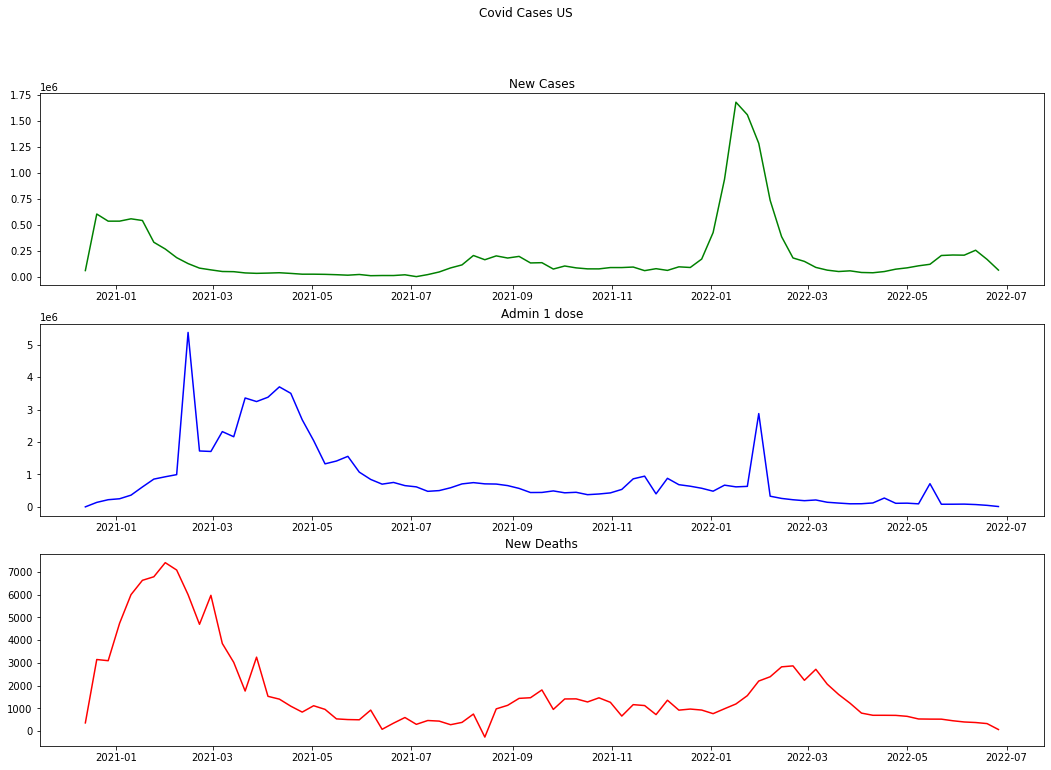

In [212]:
fig, axes = plt.subplots(nrows=3, figsize=(18,12))

axes[0].plot(df_var['new_case'],color = 'green');
axes[1].plot(df_var['Admin_Dose_1_Daily'], color = 'blue');
axes[2].plot(df_var['new_death'], color = 'red');

fig.suptitle('Covid Cases US')
axes[0].title.set_text('New Cases')
axes[1].title.set_text('Admin 1 dose')
axes[2].title.set_text('New Deaths')